In [1]:
import os
import logging
from pathlib import Path

import scanpy as sc
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import wandb
from pytorch_lightning.loggers import WandbLogger

In [2]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import mushroom.utils as utils
from mushroom.models.expression_prediction import STExpressionLightning
from mushroom.learners import HEExpressionPredictor, STExpressionLearner

## load data

In [6]:
project = 'expression_model'
log_dir = '/data/estorrs/mushroom/data/models/expression_v1'
Path(log_dir).mkdir(parents=True, exist_ok=True)

In [7]:
genes = [
    'IL7R',
    'CD8A',
    'SPARC',
    'BGN',
    'VIM',
    'EPCAM',
    'KRT18',
    'MS4A1',
    'PECAM1',
]

In [8]:
fps = [
    '/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U2',
    '/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U3',
    '/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U4',
    '/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U5',
]

sid_to_adata = {}
for fp in fps:
    sid = fp.split('/')[-1]
    a = sc.read_visium(fp)
    a.var_names_make_unique()
    a = a[:, genes]
    sid_to_adata[sid] = a
sid_to_adata.keys()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


dict_keys(['BR_206B1_U2', 'BR_206B1_U3', 'BR_206B1_U4', 'BR_206B1_U5'])

In [9]:
fps = {
    'BR_206B1_U2': '/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U2.tif',
    'BR_206B1_U3': '/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U3.tif',
    'BR_206B1_U4': '/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U4.tif',
    'BR_206B1_U5': '/data/spatial_transcriptomics/highres_images/breast/20201103_ST_HT206B1-S1Fc1U5.tif',
}

sid_to_he = {sid:tifffile.imread(fp) for sid, fp in fps.items()}
sid_to_he.keys()

dict_keys(['BR_206B1_U2', 'BR_206B1_U3', 'BR_206B1_U4', 'BR_206B1_U5'])

In [10]:
train_ids = ['BR_206B1_U2', 'BR_206B1_U3', 'BR_206B1_U4']
val_ids = ['BR_206B1_U5']

train_adatas = {sid:sid_to_adata[sid] for sid in train_ids}
val_adatas = {sid:sid_to_adata[sid] for sid in val_ids}

train_hes = {sid:sid_to_he[sid] for sid in train_ids}
val_hes = {sid:sid_to_he[sid] for sid in val_ids}

In [11]:
config = {
    'training': {
        'max_epochs': 30,
        'log_every': 1,
        'chkpt_every': 5,
        'limit_train_batches': 1.,
        'limit_val_batches': .1,
        'accelerator': 'gpu',
        'devices': [0],
        'lr': 2e-5,
    },
}

In [12]:
logger = WandbLogger(project=project, save_dir=log_dir)

In [13]:
# wandb.finish()

In [13]:
learner = STExpressionLearner(train_adatas, val_adatas, train_hes, val_hes, config, logger=logger, num_workers=30)

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [14]:
learner.fit()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /data/estorrs/mushroom/data/models/expression_v1/ckpts exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type              | Params
--------------------------------------------
0 | model | STExpressionModel | 45.2 M
--------------------------------------------
45.2 M    Trainable params
0         Non-trainable params
45.2 M    Total params
180.604   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
Process Process-736:
Process Process-740:
Process Process-741:
Process Process-742:
Process Process-739:
Process Process-743:
Process Process-746:
Process Process-745:
Process Process-737:
Process Process-738:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
Tra

  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/threading.py", line 1096, in join
    self._wait_for_tstate_lock()
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/multiprocessing/queues.py", line 199, in _finalize_join
    thread.join()
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/multiprocessing/queues.py", line 199, in _finalize_join
    thread.join()
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/threading.py", line 1096, in join
    self._wait_for_tstate_lock()
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/threading.py", line 1096, in join
    self._wait_for_tstate_lock()
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/threading.py", line 1116, in _wait_for_tstate_lock
    if lock.acquire(block, timeout):
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3

In [16]:
learner.trainer.save_checkpoint(os.path.join(log_dir, "ckpts", 'model.pt'))

In [12]:
model = STExpressionLightning.load_from_checkpoint(os.path.join(log_dir, "ckpts", 'model.pt'))

In [188]:
predictor = HEExpressionPredictor(model)

genes = None
sid_to_exp = {}
for sid, he in sid_to_he.items():
    img, genes = predictor.predict(he)
    sid_to_exp[sid] = img
sid_to_exp.keys()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

dict_keys(['BR_206B1_U2', 'BR_206B1_U3', 'BR_206B1_U4', 'BR_206B1_U5'])

In [71]:
genes

['IL7R', 'CD8A', 'SPARC', 'BGN', 'VIM', 'EPCAM', 'KRT18', 'MS4A1', 'PECAM1']

In [190]:
cuts = {
    'IL7R': .7,
    'EPCAM': .95,
    'BGN': .6
}
sid_to_masks = {}
for sid, img in sid_to_exp.items():
    subsampled = TF.resize(img, (int(img.shape[-2] * .1), int(img.shape[-1] * .1))).to(torch.float32)
    subsampled = TF.gaussian_blur(subsampled, 43)
    subsampled -= rearrange(rearrange(subsampled, 'c h w -> c (h w)').min(dim=1).values, 'b -> b 1 1')
    subsampled /= rearrange(rearrange(subsampled, 'c h w -> c (h w)').max(dim=1).values, 'b -> b 1 1')
    
    new = torch.zeros((len(cuts), subsampled.shape[1], subsampled.shape[2]), dtype=torch.bool)
    for i, (gene, val) in enumerate(cuts.items()):
        gene_idx = genes.index(gene)
        new[i] = subsampled[gene_idx] > val
    
    sid_to_masks[sid] = new
        
        

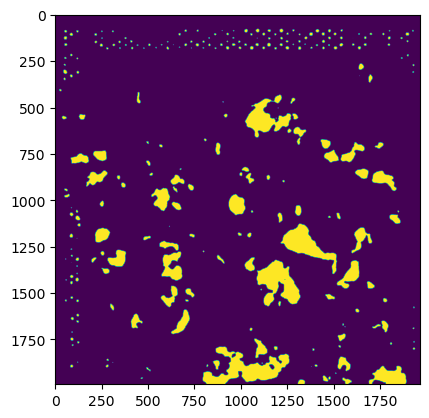

In [192]:
plt.imshow(sid_to_masks['BR_206B1_U3'][0])

In [193]:
out_dir = '/data/estorrs/sandbox/mushroom/data/test_classes'
Path(out_dir).mkdir(parents=True, exist_ok=True)

for sid, masks in sid_to_masks.items():
    np.save(os.path.join(out_dir, f'{sid}.npy'), masks.numpy())

In [72]:
sid = 'BR_206B1_U2'

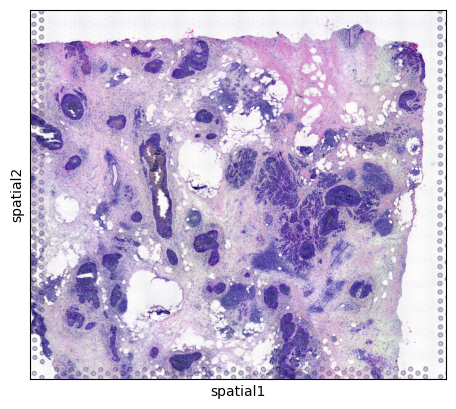

In [73]:
a = sid_to_adata[sid]
sc.pl.spatial(a)

In [74]:
img = sid_to_exp[sid]

In [169]:
import torchvision.transforms.functional as TF

subsampled = TF.resize(img, (int(img.shape[-2] * .1), int(img.shape[-1] * .1))).to(torch.float32)
subsampled = TF.gaussian_blur(subsampled, 43)
subsampled -= rearrange(rearrange(subsampled, 'c h w -> c (h w)').min(dim=1).values, 'b -> b 1 1')
subsampled /= rearrange(rearrange(subsampled, 'c h w -> c (h w)').max(dim=1).values, 'b -> b 1 1')

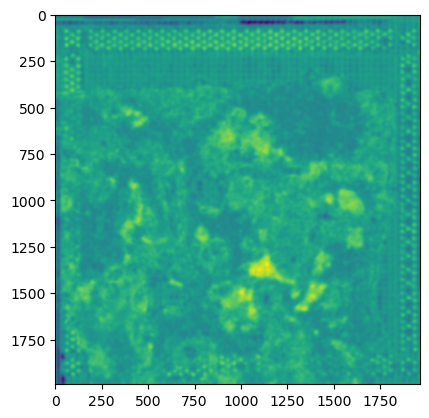

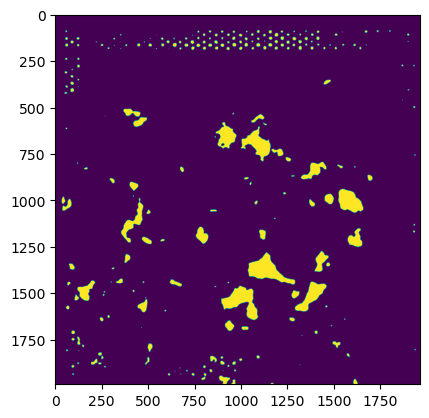

In [178]:
gene = 'IL7R'
gene_idx = genes.index(gene)
cut = .7
plt.imshow(subsampled[gene_idx])
plt.show()
plt.imshow(subsampled[gene_idx]>cut)
plt.show()

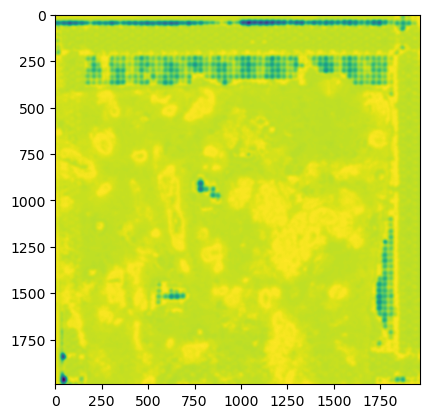

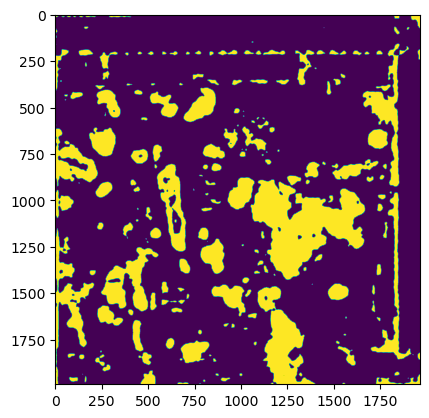

In [184]:
gene = 'EPCAM'
gene_idx = genes.index(gene)
cut = .95
plt.imshow(subsampled[gene_idx])
plt.show()
plt.imshow(subsampled[gene_idx]>cut)
plt.show()

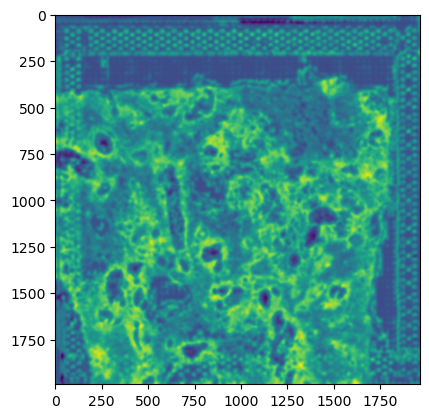

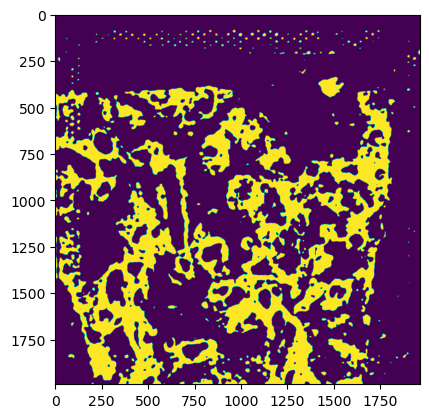

In [187]:
gene = 'BGN'
gene_idx = genes.index(gene)
cut = .6
plt.imshow(subsampled[gene_idx])
plt.show()
plt.imshow(subsampled[gene_idx]>cut)
plt.show()